In [5]:
!pip install ortools -q
# download codes
!git clone https://github.com/rilianx/eda.git

fatal: destination path 'eda' already exists and is not an empty directory.


In [19]:
import pandas as pd
df = pd.DataFrame(columns=["cities", "iter", "Epoch",
                           "Training Loss", "Training Accuracy",
                           "Validation Loss", "Validation Accuracy"])
eval_df = pd.DataFrame(columns=["model_name", "cost"])


## Creación del Modelo

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, input_dim, num_heads, head_dim, dropout_rate=0.2):
        super(CustomModel, self).__init__()
        #self.seq_length = seq_length  # Asumiendo una longitud fija de secuencia para simplificar
        self.num_heads = num_heads
        self.head_dim = head_dim

        # Proyección de entrada
        self.input_projection = nn.Linear(input_dim, num_heads * head_dim)

        # Capa de atención multi-cabeza
        self.multihead_attention = nn.MultiheadAttention(embed_dim=num_heads * head_dim,
                                                         num_heads=num_heads,
                                                         dropout=dropout_rate)

        # En el __init__ del modelo
        self.norm1 = nn.LayerNorm(num_heads * head_dim)  # Para salida de atención
        self.norm2 = nn.LayerNorm(num_heads * head_dim)  # Para salida de la capa densa

        # Definir una capa densa adicional en tu init
        self.dense_layer = nn.Sequential(
            nn.Linear(self.num_heads * self.head_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Capa de salida final, después de un flatten, para aplicar Softmax
        # Nota: Softmax se aplica después del flatten, por lo tanto no se define aquí como una capa pero sí en el forward

    def generate_attention_mask(self, x, num_heads, padding_value=0):
        # Identificar posiciones de padding en x
        mask = (x.sum(dim=-1) == padding_value)  # [batch_size, seq_length]
        mask = mask.unsqueeze(1).expand(-1, x.size(1), -1)  # Expandir a [batch_size, seq_length, seq_length]
        mask = mask.unsqueeze(1).expand(-1, num_heads, -1, -1)  # Expandir para incluir num_heads: [batch_size, num_heads, seq_length, seq_length]
        mask = mask.reshape(-1, x.size(1), x.size(1))  # Ajustar a [batch_size * num_heads, seq_length, seq_length]
        mask = mask.to(dtype=torch.bool)  # Convertir a bool para usar como máscara
        return mask


    def forward(self, x, seq_lengths=10, return_probabilities=False):
        # x: [batch_size, seq_length, input_dim]
        x = x.float()

        max_len = x.shape[1]

        # Generar máscara de atención basada en las longitudes de las secuencias
        attn_mask = self.generate_attention_mask(x, num_heads)

        # Aplicar proyección de entrada
        x_proj = self.input_projection(x)
        x_proj = x_proj.permute(1, 0, 2)  # Reordenar para multihead_attention: [seq_length, batch_size, num_heads*head_dim]


        # Aplicar atención multi-cabeza
        attn_output, _ = self.multihead_attention(x_proj, x_proj, x_proj, attn_mask=attn_mask)
        attn_output = attn_output.permute(1, 0, 2)  # Reordenar de vuelta: [batch_size, seq_length, num_heads*head_dim]
        #attn_output = self.norm1(attn_output + x_proj)  # Residual + Normalización


        # Aplicar capas densas vector por vector
        dense_output = self.dense_layer(attn_output)
        #dense_output = self.norm2(dense_output + attn_output)  # Residual + Normalización



        # Flatten
        flat_output = dense_output.view(dense_output.size(0), -1)  # [batch_size, seq_length]

        # Softmax
        if return_probabilities:
          output = F.softmax(flat_output, dim=-1)
          return output
        else: #return logits
          return flat_output



# Parámetros del modelo
input_dim = 6  # Dimensión de la entrada
num_heads = 10  # Número de cabezas en la atención multi-cabeza
head_dim = 64  # Dimensión de cada cabeza


# Crear el modelo
model = CustomModel(input_dim=input_dim, num_heads=num_heads, head_dim=head_dim)

# Información del modelo (Opcional)
print(model)


CustomModel(
  (input_projection): Linear(in_features=6, out_features=640, bias=True)
  (multihead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
  )
  (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
  (dense_layer): Sequential(
    (0): Linear(in_features=640, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


## Generación de datos usando **Algoritmo clásico**

In [8]:
from copy import deepcopy
import random
import math

def distance(punto1, punto2):
    return math.sqrt((punto1[0] - punto2[0])**2 + (punto1[1] - punto2[1])**2)

# función para transformar un estado tsp en una secuencia de vectores
# para el modelo basado en capas de atención
def state2vecSeq(self):
    # creamos dos diccionarios para mantenre un mapeo de los
    # movimientos con los índices de la secuencia del modelo de aprendizaje

    city_locations = self.inst_info.city_locations

    idx2move = dict()
    move2idx = dict()
    origin = city_locations[self.visited[-1]]
    destination = city_locations[self.visited[0]]

    origin_dist = 0.0
    dest_dist = distance(origin, destination)

    seq = [list(origin) + [1,0] + [origin_dist, dest_dist], # Última ciudad visitada (origen)
           list(destination) + [0, 1] + [dest_dist, 0.0]]  # Ciudad final

    idx2move[0] = None
    idx2move[1] = ("constructive", self.visited[0])
    move2idx[self.visited[0]] = 1

    idx = 2
    for i in self.not_visited:
        point = list(city_locations[i])
        origin_dist = distance( point, origin)
        dest_dist = distance( point, destination)
        city_vector = point + [0, 0] + [origin_dist, dest_dist] # Otras ciudades

        seq.append(city_vector)
        idx2move[idx] = ("constructive", i)
        move2idx[i] = idx
        idx += 1

    return seq, idx2move, move2idx

In [9]:
import numpy as np
from torch.nn.functional import one_hot
from eda.TSP import TSP_Instance, TSP_Environment, TSP_State
from eda.solveTSP_v2 import solve
env = TSP_Environment

def generate_data(max_cities=20, nb_sample=100):
    X = []  # Lista para almacenar las secuencias de entrada
    Y = []  # Lista para almacenar las etiquetas objetivo (las siguientes ciudades a visitar)
    seq_len = max_cities + 1  # Longitud de la secuencia, ajustada para incluir una ciudad extra

    # Bucle para generar datos hasta alcanzar el número deseado de muestras
    while True:
        # 1. Generamos instancia aleatoria
        n_cities = max_cities
        dim = 2  # Dimensión para las coordenadas de la ciudad (2D: x, y)
        city_points = np.random.rand(n_cities, dim)  # Generar puntos aleatorios para las ciudades
        inst_info = TSP_Instance(city_points)

        # 2. Resolvemos TSP usando algoritmo tradicional
        solution = solve(city_points)  # Resolver el TSP y obtener un estado final

        # 3. Iteramos sobre los movimientos de la solución final para generar varias muestras:
        # estado (X) -> movimiento (Y)
        current_state = TSP_State (inst_info)
        env.state_transition(current_state, ("constructive",solution.visited[0]))
        samples_per_sol = max_cities-1  # Número máximo de muestras por solución
        for move in [("constructive", city) for city in solution.visited[1:]]:
            seq, _, move2idx = state2vecSeq(current_state)  # Convertir el estado actual a secuencia vectorizada

            X.append(torch.tensor(seq))  # Añadir la secuencia a X
            Y.append(one_hot(torch.tensor(move2idx[move[1]]), num_classes=seq_len))
            #Y.append(to_categorical(move2idx[move[1]], num_classes=seq_len))  # Añadir el movimiento como categoría a Y

            env.state_transition(current_state, move)  # Hacer la transición al siguiente estado

            # Condiciones de parada basadas en el número de ciudades visitadas/no visitadas o muestras generadas
            if len(current_state.visited) > samples_per_sol or len(X) >= nb_sample:
                break

        # Romper el bucle externo si se ha alcanzado el número deseado de muestras
        if len(X) >= nb_sample:
            break

    X_padded = torch.nn.utils.rnn.pad_sequence(X, batch_first=True)

    return X_padded, torch.stack(Y)

generate_data(5,4)

(tensor([[[0.4890, 0.5984, 1.0000, 0.0000, 0.0000, 0.0000],
          [0.4890, 0.5984, 0.0000, 1.0000, 0.0000, 0.0000],
          [0.7056, 0.7737, 0.0000, 0.0000, 0.2786, 0.2786],
          [0.0432, 0.4913, 0.0000, 0.0000, 0.4585, 0.4585],
          [0.1375, 0.8891, 0.0000, 0.0000, 0.4561, 0.4561],
          [0.0016, 0.2660, 0.0000, 0.0000, 0.5900, 0.5900]],
 
         [[0.7056, 0.7737, 1.0000, 0.0000, 0.0000, 0.2786],
          [0.4890, 0.5984, 0.0000, 1.0000, 0.2786, 0.0000],
          [0.0432, 0.4913, 0.0000, 0.0000, 0.7201, 0.4585],
          [0.1375, 0.8891, 0.0000, 0.0000, 0.5797, 0.4561],
          [0.0016, 0.2660, 0.0000, 0.0000, 0.8680, 0.5900],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
 
         [[0.1375, 0.8891, 1.0000, 0.0000, 0.0000, 0.4561],
          [0.4890, 0.5984, 0.0000, 1.0000, 0.4561, 0.0000],
          [0.0432, 0.4913, 0.0000, 0.0000, 0.4088, 0.4585],
          [0.0016, 0.2660, 0.0000, 0.0000, 0.6377, 0.5900],
          [0.0000, 0.0000, 0.0000,

In [18]:
from eda.TSP import TSP_Instance, TSP_Environment, TSP_State, evalConstructiveActions, plot_tour
from eda.agents import SingleAgentSolver, GreedyAgent
import numpy as np
import pickle

#with open('tsp_model.pkl', 'rb') as archivo:
#    model = pickle.load(archivo)

class ModelEvalActions():
  def __init__(self, model):
    self.model=model

  # permite evaluar acctiones de varios estados a la vez
  # para optimizar los cáluclos del modelo
  def __call__(self, states, env):
    single_state = False
    if not isinstance(states, list):
      single_state=True
      states = [states]

    evals = [list() for _ in states]
    vecSeqs=[]; move2idx =[]

    for state in states:
      vecSeq, _, mov2idx = state.state2vecSeq()
      vecSeqs.append(vecSeq)
      move2idx.append(mov2idx)

    predictions = self.model(torch.tensor(vecSeqs), return_probabilities=True)

    for k in range(len(states)):
      state = states[k]
      for action in env.gen_actions(state, "constructive"):
          idx = move2idx[k][action[1]] #mapping from move to output index (model)
          evals[k].append((action,predictions[k][idx]))

    if single_state: return evals[0]
    else: return evals


In [10]:
from sklearn.model_selection import train_test_split
X,Y=generate_data(max_cities=50, nb_sample=20000) ## Actualización a 50 ciudades
print(X.shape,Y.shape)

torch.Size([20000, 51, 6]) torch.Size([20000, 51])


## Entrenamiento del modelo

In [21]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
df = pd.DataFrame(columns=["cities", "iter", "Epoch",
                           "Training Loss", "Training Accuracy",
                           "Validation Loss", "Validation Accuracy"])
eval_df = pd.DataFrame(columns=["model_name", "cost"])

# Asumiendo que X_padded y Y_stacked ya están definidos y son tensores de PyTorch
dataset = TensorDataset(X, Y)

# Dividir el dataset en entrenamiento y prueba}
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Definir el modelo, la función de pérdida y el optimizador
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Ciclo de entrenamiento
epochs = 5
for num_iter in range(10):
    model = CustomModel(input_dim=input_dim, num_heads=num_heads, head_dim=head_dim)
    # Definir el modelo, la función de pérdida y el optimizador
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0; total = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Limpia los gradientes
            outputs = model(X_batch)  # Obtenemos logits
            loss = loss_function(outputs, y_batch.argmax(dim=1))  # Calcular la pérdida
            loss.backward()  # Backward pass
            optimizer.step()  # Actualizar parámetros
            train_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch.argmax(dim=1)).sum().item()
    
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct / total
    
        # Validación
        model.eval()
        validation_loss = 0
        correct = 0; total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = loss_function(outputs, y_batch.argmax(dim=1))
                validation_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.argmax(dim=1)).sum().item()
        validation_loss /= len(test_loader.dataset)
        validation_accuracy = 100 * correct / total
    
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Epoch {epoch+1}, Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%')
        df = pd.concat([df, pd.DataFrame([{
            "cities": 50,
            "iter": num_iter,
            "Epoch": epoch + 1,
            "Training Loss": train_loss,
            "Training Accuracy": train_accuracy,
            "Validation Loss": validation_loss,
            "Validation Accuracy": validation_accuracy
        }])], ignore_index=True)

    from tqdm import tqdm
    nb_eval = 50
    instances = [
                    TSP_Instance(np.random.rand(50, 2)) for _ in tqdm(
                        range(50), desc="Instances", unit="instance", position=0, leave=True
                    )
                ]
    greedy = SingleAgentSolver(env, GreedyAgent(ModelEvalActions(model)))
    solutions = []
    
    for instance in tqdm(instances, desc="Solving Instances", unit="instance", position=0, leave=True):
        solution, *_ = greedy.solve(TSP_State(instance, visited=[0]))
        eval_df = pd.concat([eval_df, pd.DataFrame([{
            "model_name" : type(model).__name__,
            "iter" : num_iter,        
            "cost": solution.cost,                
    }]) ])




Epoch 1, Train Loss: 1.1804, Train Accuracy: 65.62%
Epoch 1, Val Loss: 0.5609, Val Accuracy: 82.98%


C:\Users\krr\AppData\Local\Temp\ipykernel_58824\2295487975.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


Epoch 2, Train Loss: 0.6306, Train Accuracy: 79.45%
Epoch 2, Val Loss: 0.5593, Val Accuracy: 83.11%
Epoch 3, Train Loss: 0.6082, Train Accuracy: 79.91%
Epoch 3, Val Loss: 0.5880, Val Accuracy: 83.18%
Epoch 4, Train Loss: 0.6066, Train Accuracy: 79.89%
Epoch 4, Val Loss: 0.5681, Val Accuracy: 82.92%
Epoch 5, Train Loss: 0.5959, Train Accuracy: 80.42%
Epoch 5, Val Loss: 0.5613, Val Accuracy: 83.23%


Solving Instances:   0%|                                                                  | 0/50 [00:00<?, ?instance/s]C:\Users\krr\AppData\Local\Temp\ipykernel_58824\2295487975.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, pd.DataFrame([{
Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.86instance/s]


Epoch 1, Train Loss: 1.2311, Train Accuracy: 63.95%
Epoch 1, Val Loss: 0.5761, Val Accuracy: 82.72%
Epoch 2, Train Loss: 0.6212, Train Accuracy: 79.83%
Epoch 2, Val Loss: 0.5524, Val Accuracy: 82.93%
Epoch 3, Train Loss: 0.6033, Train Accuracy: 80.20%
Epoch 3, Val Loss: 0.5534, Val Accuracy: 83.62%
Epoch 4, Train Loss: 0.6097, Train Accuracy: 80.25%
Epoch 4, Val Loss: 0.5386, Val Accuracy: 83.54%
Epoch 5, Train Loss: 0.5842, Train Accuracy: 80.59%
Epoch 5, Val Loss: 0.5328, Val Accuracy: 83.76%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.50instance/s]


Epoch 1, Train Loss: 1.1927, Train Accuracy: 65.10%
Epoch 1, Val Loss: 0.5625, Val Accuracy: 82.89%
Epoch 2, Train Loss: 0.6210, Train Accuracy: 79.74%
Epoch 2, Val Loss: 0.5573, Val Accuracy: 83.17%
Epoch 3, Train Loss: 0.6117, Train Accuracy: 80.35%
Epoch 3, Val Loss: 0.5743, Val Accuracy: 82.91%
Epoch 4, Train Loss: 0.6158, Train Accuracy: 79.56%
Epoch 4, Val Loss: 0.5594, Val Accuracy: 83.36%
Epoch 5, Train Loss: 0.5854, Train Accuracy: 80.60%
Epoch 5, Val Loss: 0.5463, Val Accuracy: 83.49%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.96instance/s]


Epoch 1, Train Loss: 1.2290, Train Accuracy: 64.29%
Epoch 1, Val Loss: 0.5848, Val Accuracy: 82.81%
Epoch 2, Train Loss: 0.6273, Train Accuracy: 79.61%
Epoch 2, Val Loss: 0.5509, Val Accuracy: 83.06%
Epoch 3, Train Loss: 0.6101, Train Accuracy: 79.81%
Epoch 3, Val Loss: 0.5871, Val Accuracy: 83.29%
Epoch 4, Train Loss: 0.6324, Train Accuracy: 79.68%
Epoch 4, Val Loss: 0.5753, Val Accuracy: 82.83%
Epoch 5, Train Loss: 0.6135, Train Accuracy: 79.64%
Epoch 5, Val Loss: 0.6062, Val Accuracy: 83.02%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.83instance/s]


Epoch 1, Train Loss: 1.2410, Train Accuracy: 64.75%
Epoch 1, Val Loss: 0.5907, Val Accuracy: 82.60%
Epoch 2, Train Loss: 0.6265, Train Accuracy: 79.28%
Epoch 2, Val Loss: 0.5520, Val Accuracy: 83.42%
Epoch 3, Train Loss: 0.6126, Train Accuracy: 79.94%
Epoch 3, Val Loss: 0.5688, Val Accuracy: 83.51%
Epoch 4, Train Loss: 0.6086, Train Accuracy: 79.93%
Epoch 4, Val Loss: 0.5552, Val Accuracy: 83.41%
Epoch 5, Train Loss: 0.6061, Train Accuracy: 80.05%
Epoch 5, Val Loss: 0.5499, Val Accuracy: 83.54%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.32instance/s]


Epoch 1, Train Loss: 1.2444, Train Accuracy: 64.33%
Epoch 1, Val Loss: 0.5693, Val Accuracy: 82.91%
Epoch 2, Train Loss: 0.6183, Train Accuracy: 79.89%
Epoch 2, Val Loss: 0.5484, Val Accuracy: 83.11%
Epoch 3, Train Loss: 0.6115, Train Accuracy: 80.37%
Epoch 3, Val Loss: 0.5692, Val Accuracy: 83.27%
Epoch 4, Train Loss: 0.6010, Train Accuracy: 80.29%
Epoch 4, Val Loss: 0.5746, Val Accuracy: 83.63%
Epoch 5, Train Loss: 0.6014, Train Accuracy: 80.41%
Epoch 5, Val Loss: 0.5621, Val Accuracy: 83.28%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.32instance/s]


Epoch 1, Train Loss: 1.2402, Train Accuracy: 64.02%
Epoch 1, Val Loss: 0.5705, Val Accuracy: 82.87%
Epoch 2, Train Loss: 0.6158, Train Accuracy: 79.57%
Epoch 2, Val Loss: 0.5823, Val Accuracy: 82.89%
Epoch 3, Train Loss: 0.6254, Train Accuracy: 79.27%
Epoch 3, Val Loss: 0.5579, Val Accuracy: 82.97%
Epoch 4, Train Loss: 0.6039, Train Accuracy: 80.22%
Epoch 4, Val Loss: 0.6090, Val Accuracy: 82.57%
Epoch 5, Train Loss: 0.5939, Train Accuracy: 80.41%
Epoch 5, Val Loss: 0.5434, Val Accuracy: 83.58%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.56instance/s]


Epoch 1, Train Loss: 1.2262, Train Accuracy: 64.43%
Epoch 1, Val Loss: 0.5660, Val Accuracy: 82.91%
Epoch 2, Train Loss: 0.6097, Train Accuracy: 79.79%
Epoch 2, Val Loss: 0.5552, Val Accuracy: 82.94%
Epoch 3, Train Loss: 0.6065, Train Accuracy: 80.25%
Epoch 3, Val Loss: 0.5518, Val Accuracy: 83.40%
Epoch 4, Train Loss: 0.6079, Train Accuracy: 80.09%
Epoch 4, Val Loss: 0.5878, Val Accuracy: 83.55%
Epoch 5, Train Loss: 0.5994, Train Accuracy: 80.46%
Epoch 5, Val Loss: 0.5787, Val Accuracy: 83.62%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.52instance/s]


Epoch 1, Train Loss: 1.2367, Train Accuracy: 63.86%
Epoch 1, Val Loss: 0.5643, Val Accuracy: 83.08%
Epoch 2, Train Loss: 0.6241, Train Accuracy: 79.37%
Epoch 2, Val Loss: 0.5509, Val Accuracy: 83.06%
Epoch 3, Train Loss: 0.6107, Train Accuracy: 79.51%
Epoch 3, Val Loss: 0.5435, Val Accuracy: 83.44%
Epoch 4, Train Loss: 0.5927, Train Accuracy: 80.38%
Epoch 4, Val Loss: 0.5391, Val Accuracy: 83.62%
Epoch 5, Train Loss: 0.5967, Train Accuracy: 80.72%
Epoch 5, Val Loss: 0.5396, Val Accuracy: 83.75%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.70instance/s]


Epoch 1, Train Loss: 1.2114, Train Accuracy: 64.82%
Epoch 1, Val Loss: 0.5984, Val Accuracy: 82.90%
Epoch 2, Train Loss: 0.6223, Train Accuracy: 79.65%
Epoch 2, Val Loss: 0.5985, Val Accuracy: 83.12%
Epoch 3, Train Loss: 0.6170, Train Accuracy: 80.04%
Epoch 3, Val Loss: 0.5543, Val Accuracy: 83.45%
Epoch 4, Train Loss: 0.5949, Train Accuracy: 80.19%
Epoch 4, Val Loss: 0.5440, Val Accuracy: 83.59%
Epoch 5, Train Loss: 0.5943, Train Accuracy: 80.70%
Epoch 5, Val Loss: 0.5592, Val Accuracy: 83.51%


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.63instance/s]


In [23]:
df.to_csv("base_train_v2.csv")
eval_df.to_csv("base_eval_v2.csv")

In [24]:
eval_df

,model_name,cost,iter
0,CustomModel,7.639725,0.0
0,CustomModel,6.718356,0.0
0,CustomModel,6.367737,0.0
0,CustomModel,6.971945,0.0
0,CustomModel,6.664156,0.0
...,...,...,...
0,CustomModel,5.875302,9.0
0,CustomModel,8.367726,9.0
0,CustomModel,6.204966,9.0
0,CustomModel,6.255936,9.0


## Validación del modelo.
Se utiliza como función de evaluación de movimientos dentro de algoritmo constructivo Greedy

Model solution:
 Tour actual: [0, 69, 27, 57, 98, 60, 63, 91, 26, 56, 17, 25, 99, 96, 40, 93, 46, 1, 43, 37, 78, 4, 68, 12, 53, 80, 22, 92, 79, 45, 33, 82, 3, 21, 16, 34, 5, 95, 36, 50, 84, 64, 20, 76, 13, 32, 8, 23, 51, 62, 11, 42, 97, 30, 9, 65, 83, 55, 61, 18, 41, 72, 54, 2, 7, 28, 74, 29, 66, 49, 90, 39, 86, 94, 24, 15, 10, 87, 14, 85, 38, 58, 35, 6, 75, 52, 70, 77, 89, 67, 31, 44, 59, 47, 19, 88, 71, 48, 73, 81, 0], 
Coste total: 8.435653369923232


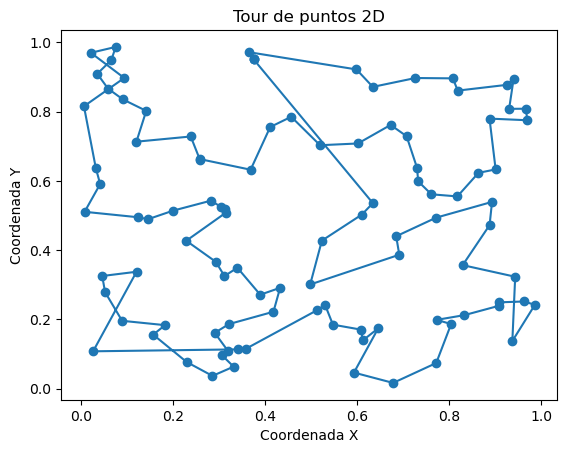

Greedy solution:
 Tour actual: [0, 69, 12, 53, 68, 4, 78, 37, 43, 1, 46, 93, 47, 19, 88, 31, 67, 70, 77, 75, 52, 6, 58, 35, 38, 85, 14, 10, 15, 87, 24, 86, 94, 71, 9, 30, 65, 83, 55, 61, 18, 90, 39, 41, 72, 54, 2, 7, 28, 74, 29, 66, 62, 11, 42, 97, 51, 23, 8, 32, 13, 76, 20, 64, 84, 50, 45, 33, 82, 3, 95, 16, 34, 5, 21, 36, 79, 22, 92, 80, 48, 73, 81, 40, 96, 59, 44, 99, 56, 17, 25, 91, 26, 63, 60, 98, 57, 27, 89, 49, 0], 
Coste total: 10.063968586445139


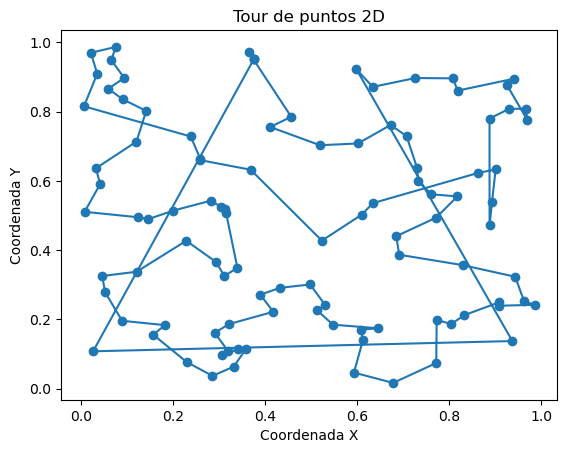

OR-Tools: 7.541261870308029


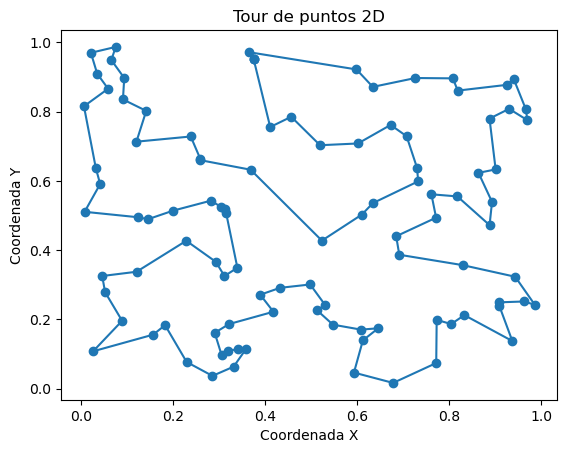

In [13]:
from eda.TSP import TSP_Instance, TSP_Environment, TSP_State, evalConstructiveActions, plot_tour
from eda.agents import SingleAgentSolver, GreedyAgent
import numpy as np
import pickle

#with open('tsp_model.pkl', 'rb') as archivo:
#    model = pickle.load(archivo)

class ModelEvalActions():
  def __init__(self, model):
    self.model=model

  # permite evaluar acctiones de varios estados a la vez
  # para optimizar los cáluclos del modelo
  def __call__(self, states, env):
    single_state = False
    if not isinstance(states, list):
      single_state=True
      states = [states]

    evals = [list() for _ in states]
    vecSeqs=[]; move2idx =[]

    for state in states:
      vecSeq, _, mov2idx = state.state2vecSeq()
      vecSeqs.append(vecSeq)
      move2idx.append(mov2idx)

    predictions = self.model(torch.tensor(vecSeqs), return_probabilities=True)

    for k in range(len(states)):
      state = states[k]
      for action in env.gen_actions(state, "constructive"):
          idx = move2idx[k][action[1]] #mapping from move to output index (model)
          evals[k].append((action,predictions[k][idx]))

    if single_state: return evals[0]
    else: return evals

np.random.seed(42)

# creamos un problema con 50 ciudades en un plano 2D
cities  = np.random.rand(100, 2)
inst_info = TSP_Instance(cities)

# referenciamos nuestro ambiente con las "reglas del juego"
env = TSP_Environment
# creamos nuestro agente
greedy = SingleAgentSolver (env,GreedyAgent(ModelEvalActions(model)))
solution, *_ = greedy.solve(TSP_State (inst_info, visited=[0]))
print("Model solution:\n", solution)
plot_tour(cities, solution.visited)


greedy2 = SingleAgentSolver (env,GreedyAgent(evalConstructiveActions))
solution, *_ = greedy2.solve(TSP_State (inst_info, visited=[0]))
print("Greedy solution:\n", solution)
plot_tour(cities, solution.visited)

solution = solve(cities)
print ("OR-Tools:",solution.cost)
plot_tour(cities, solution.visited)


### Múltiples ejecuciones

[8.435653369923232, 8.878607329525703, 8.433637884946528, 8.435653369923232, 8.433637884946528, 8.878607329525703, 8.435653369923232, 8.435653369923232, 8.878607329525703, 8.935253912367417]
Best solution:
 Tour actual: [0, 69, 27, 57, 98, 60, 63, 91, 26, 56, 17, 25, 99, 96, 40, 93, 46, 1, 43, 37, 78, 4, 68, 12, 53, 80, 92, 22, 79, 45, 33, 82, 3, 21, 16, 34, 5, 95, 36, 50, 84, 64, 20, 76, 13, 32, 8, 23, 51, 62, 11, 42, 97, 30, 9, 65, 83, 55, 61, 18, 41, 72, 54, 2, 7, 28, 74, 29, 66, 49, 90, 39, 86, 94, 24, 15, 10, 87, 14, 85, 38, 58, 35, 6, 75, 52, 70, 77, 89, 67, 31, 44, 59, 47, 19, 88, 71, 48, 73, 81, 0], 
Coste total: 8.433637884946528


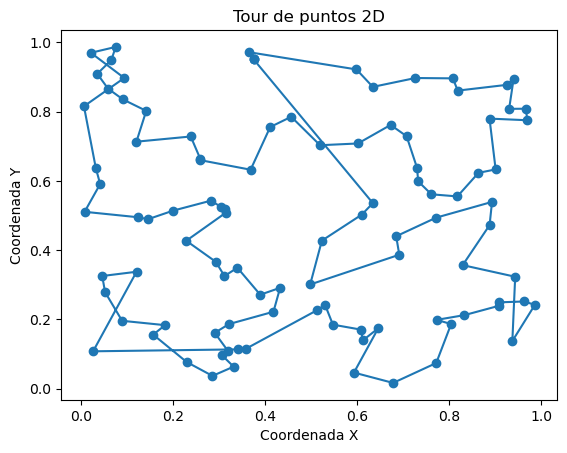

In [14]:
from eda.agents import StochasticGreedyAgent

greedy = SingleAgentSolver (env,StochasticGreedyAgent(ModelEvalActions(model), steepness=200))
solutions, *_ = greedy.multistate_solve([deepcopy(TSP_State (inst_info, visited=[0])) for _ in range(10)])

print([s.cost for s in solutions])

best_sol = min(solutions, key=lambda solution: solution.cost)
print("Best solution:\n", best_sol)
plot_tour(cities, best_sol.visited)
